<a href="https://colab.research.google.com/github/MagretAdekunle/Machine-Learning-Projects-freeCodeCamp/blob/main/Book%20Recommendation%20Engine%20using%20KNN/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [2]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load dataset

In [3]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-01-04 03:20:48--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  75.9MB/s    in 0.3s    

2025-01-04 03:20:49 (75.9 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [4]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [5]:
# Merging the dataframes
df = df_ratings.merge(df_books,on="isbn",how="left")
df.head()

,user,isbn,rating,title,author
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose
1,276726,0155061224,5.0,Rites of Passage,Judith Rae
2,276727,0446520802,0.0,The Notebook,Nicholas Sparks
3,276729,052165615X,3.0,Help!: Level 1,Philip Prowse
4,276729,0521795028,6.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather


# Visualizations for Exploratory Data Analysis (EDA)


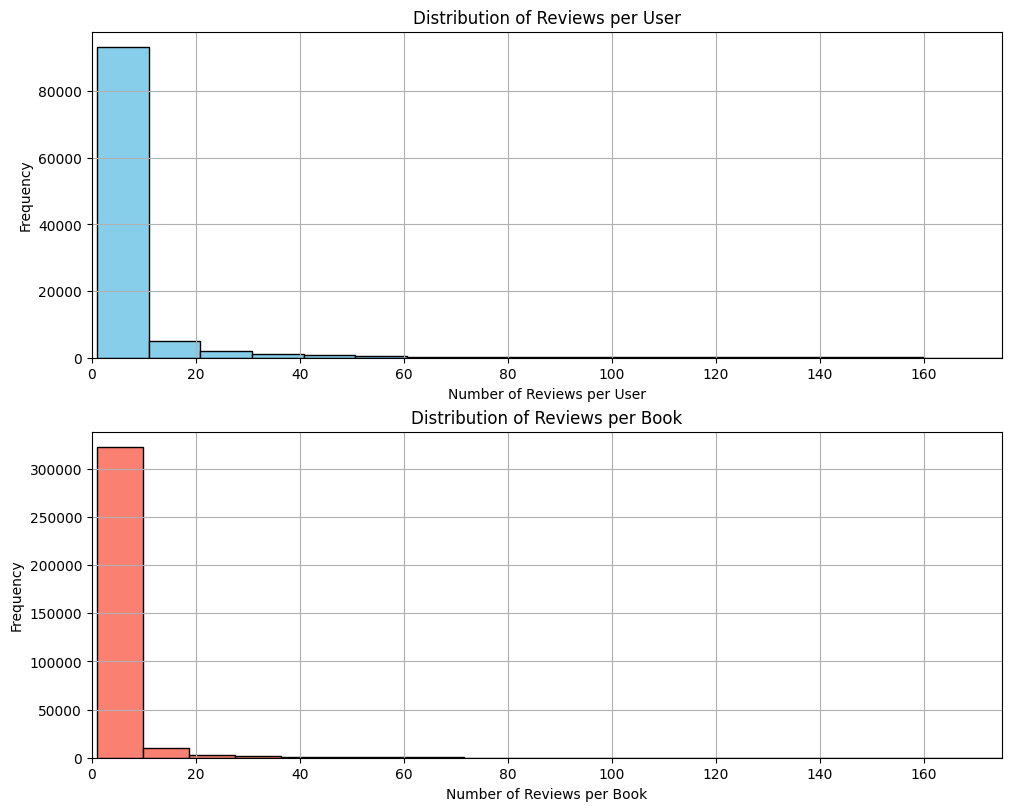

In [6]:
# Plotting the dataset for exploratory analysis
fig, axes = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

# Plot 1: Distribution of reviews per user
axes[0].set_title("Distribution of Reviews per User")
axes[0].set_xlabel("Number of Reviews per User")
axes[0].set_ylabel("Frequency")
user_unique = df["user"].value_counts()
user_unique[user_unique < 1000].hist(bins=100, ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_xlim(0, 175)

# Plot 2: Distribution of reviews per book (ISBN)
axes[1].set_title("Distribution of Reviews per Book")
axes[1].set_xlabel("Number of Reviews per Book")
axes[1].set_ylabel("Frequency")
isbn_unique = df["isbn"].value_counts()
isbn_unique[isbn_unique < 1000].hist(bins=100, ax=axes[1], color="salmon", edgecolor="black")
axes[1].set_xlim(0, 175)

# Show the plots
plt.show()

# Preprocessing Data

In [8]:
# Filter dataset to include only users with 200+ ratings and books with 100+ ratingsfiltered_users = user_unique[user_unique >= 200].index

filtered_users = user_unique[user_unique >= 200].index
filtered_books = isbn_unique[isbn_unique >= 100].index
df_filtered = df[df['user'].isin(filtered_users) & df['isbn'].isin(filtered_books)]

print(f"Filtered dataset shape: {df_filtered.shape}")

Filtered dataset shape: (49781, 5)


In [9]:
# Drop duplicates based on 'title' and 'user' columns

df_filtered = df_filtered.drop_duplicates(subset=['title', 'user'])
print(f"Shape after dropping duplicates: {df_filtered.shape}")

Shape after dropping duplicates: (49374, 5)


# Rearranging Data in A Sparse Matrix

In [10]:
# Create a pivot table with 'title' as the index, 'user' as columns, and 'rating' as values
df_filtered = df_filtered.pivot(index='title', columns='user', values='rating').fillna(0)

# Convert the pivot table values into a sparse matrix
df_sm_filtered = csr_matrix(df_filtered.values)

print(f"Shape of the sparse matrix after normalization: {df_sm_filtered.shape}")

Shape of the sparse matrix after normalization: (674, 888)


# Create  Nearest Neighbors

In [11]:
# Create the NearestNeighbors model using cosine distance metric
neigh = NearestNeighbors(metric='cosine')
neigh.fit(df_sm_filtered)

NearestNeighbors(metric='cosine')

# Function to Return Recommended Books


In [12]:
def get_recommends(book=""):
    # Ensure the book exists in the dataset
    if book not in df_filtered.index:
        return f"'{book}' not found in the dataset. Please try another book."

    # Get the row index of the book
    book_row = df_filtered.index.get_loc(book)

    # Initialize the recommendations dictionary
    recommendations = {
        "input_book": book,
        "recommendations": []
    }

    # Find nearest neighbors for the given book using the trained model
    dist, idx = neigh.kneighbors([df_sm_filtered[book_row].toarray()[0]], 11, return_distance=True)

    # Get the recommended books and distances (excluding the input book itself)
    recom_titles = df_filtered.iloc[np.flip(idx[0])[:-1]].index.to_list()
    recom_distances = list(np.flip(dist[0])[:-1])

    # Append the recommended books and distances to the dictionary
    for title, distance in zip(recom_titles, recom_distances):
        recommendations["recommendations"].append({
            "title": title,
            "distance": round(distance, 4)
        })

    return recommendations


def format_recommendations(recommendations):
    output = f"Recommendations for '{recommendations['input_book']}':\n"
    for i, rec in enumerate(recommendations['recommendations'], 1):
        output += f"{i}. {rec['title']} - Similarity Score: {rec['distance']:.4f}\n"
    return output


# Test Recommended Books Fucntions

In [13]:
# Example book to test the recommendations
get_recommends('Interview with the Vampire')

{'input_book': 'Interview with the Vampire',
 'recommendations': [{'title': 'Silence of the Lambs', 'distance': 0.8205},
  {'title': 'Harry Potter and the Chamber of Secrets (Book 2)',
   'distance': 0.8193},
  {'title': 'Catch 22', 'distance': 0.8181},
  {'title': 'The Alchemist: A Fable About Following Your Dream',
   'distance': 0.8171},
  {'title': 'Misery', 'distance': 0.8087},
  {'title': 'Harry Potter and the Prisoner of Azkaban (Book 3)',
   'distance': 0.7991},
  {'title': 'The Queen of the Damned (Vampire Chronicles (Paperback))',
   'distance': 0.7345},
  {'title': 'The Witching Hour (Lives of the Mayfair Witches)',
   'distance': 0.6936},
  {'title': 'The Tale of the Body Thief (Vampire Chronicles (Paperback))',
   'distance': 0.6202},
  {'title': 'The Vampire Lestat (Vampire Chronicles, Book II)',
   'distance': 0.608}]}

In [14]:
book_title = "Interview with the Vampire"
recommendations = get_recommends(book_title)

if isinstance(recommendations, str):
    print(recommendations)
else:
    print(format_recommendations(recommendations))

Recommendations for 'Interview with the Vampire':
1. Silence of the Lambs - Similarity Score: 0.8205
2. Harry Potter and the Chamber of Secrets (Book 2) - Similarity Score: 0.8193
3. Catch 22 - Similarity Score: 0.8181
4. The Alchemist: A Fable About Following Your Dream - Similarity Score: 0.8171
5. Misery - Similarity Score: 0.8087
6. Harry Potter and the Prisoner of Azkaban (Book 3) - Similarity Score: 0.7991
7. The Queen of the Damned (Vampire Chronicles (Paperback)) - Similarity Score: 0.7345
8. The Witching Hour (Lives of the Mayfair Witches) - Similarity Score: 0.6936
9. The Tale of the Body Thief (Vampire Chronicles (Paperback)) - Similarity Score: 0.6202
10. The Vampire Lestat (Vampire Chronicles, Book II) - Similarity Score: 0.6080



In [ ]:
# books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
# print(books)

# def test_book_recommendation():
#   test_pass = True
#   recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
#   if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
#     test_pass = False
#   recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
#   recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
#   for i in range(2):
#     if recommends[1][i][0] not in recommended_books:
#       test_pass = False
#     if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
#       test_pass = False
#   if test_pass:
#     print("You passed the challenge! 🎉🎉🎉🎉🎉")
#   else:
#     print("You haven't passed yet. Keep trying!")

# test_book_recommendation()